# Effect of $n$ on Average Treatment Effect

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch

from misc.agm import calibrateAnalyticGaussianMechanism

%matplotlib inline

# set random seed
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# no. experiments, no. draws of z, no. samples, dim, X
ne = 100
nd = 1
ns = [700, 1200, 1700, 2200, 2700]
dim = 50

In [3]:
# no. of points used to fit log reg
nf = [500, 1000, 1500, 2000, 2500]

# privacy parameters
epses = [0.1, 0.3, 0.5]
delta = 1e-6

# regularisation coefficient
reg_co = 0.1

In [4]:
# vectors for generating Y, differentiate between Y_0 and Y_1 with true treatment effect tau
# Y = beta^T X + 0.1 Z
# Y_1 = Y + tau, Y_0 = Y
beta_std = 1
beta_dist = torch.distributions.normal.Normal(
    torch.tensor([0], dtype=torch.float64), 
    torch.tensor([beta_std], dtype=torch.float64)
)
beta = beta_dist.sample((dim, 1)).reshape(dim, 1)

# true treatment effect tau
tau = 2

In [5]:
# vectors for generating T
# T = exp(-T_w^T X + b)
T_std = 1
T_dist = torch.distributions.normal.Normal(
    torch.tensor([0.0], dtype=torch.float64), 
    torch.tensor([T_std], dtype=torch.float64)
)
T_w = T_dist.sample((dim, 1)).reshape(dim, 1)
T_b = 0

In [6]:
class Log_Reg(torch.nn.Module):
    '''
    Logistic Regression
    '''
    def __init__(self, D_in, D_out):
        super(Log_Reg, self).__init__()
        self.linear = torch.nn.Linear(D_in, D_out, bias=False)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [7]:
def IPTW_PPS(
    X, T, prob_vec, Y, tau, epses, delta, reg_co, nd, nf
):
    '''
    average treatment effect with inverse probability of treatment weighting using private propensity scores
    '''
    # get # experiments, # samples, # dimensions
    ne, ns, dim = X.shape

    # sgd step size
    step_size = 0.01

    ################
    # process data #
    ################

    # get Y0 and Y1
    Y0 = Y * (1 - T)
    Y1 = (Y + tau) * T

    # split data
    # get splits
    fit_split = nf
    est_split = ns - nf

    # permute indices
    perm = torch.stack(
        [torch.randperm(ns) for i in range(ne)]
    )

    # create splits
    s0 = perm[:, :fit_split]
    s1 = perm[:, fit_split:]

    # create auxiliary indices
    idx = torch.arange(ne)[:, None]

    # split X into fit, estimate splits
    X_s0 = X[idx, s0]
    X_s1 = X[idx, s1]

    # expand dim of T to allow multiplication with X
    T_ex_dim = T.reshape(ne, ns, 1)

    # split X0 and X1 into fit, estimate splits
    X0_s1 = (X * (1 - T_ex_dim))[idx, s1]
    X1_s1 = (X * T_ex_dim)[idx, s1]

    # precompute ||X0_sl||_2^2 and ||X1_sl||_2^2
    X0_s1_2 = X0_s1.norm(dim=2) ** 2
    X1_s1_2 = X1_s1.norm(dim=2) ** 2

    # add x_i to x_j for X0_plus_X0_s1 and X1_plus_X1_s1
    X0_plus_X0_s1 = X0_s1.reshape(
        ne, est_split, 1, dim
    ) + X0_s1.reshape(ne, 1, est_split, dim)
    X1_plus_X1_s1 = X1_s1.reshape(
        ne, est_split, 1, dim
    ) + X1_s1.reshape(ne, 1, est_split, dim)

    # get norms squared for X0_plus_X0_s1 and X1_plus_X1_sl
    X0_plus_X0_sl_norm_2 = X0_plus_X0_s1.norm(dim=-1) ** 2
    X1_plus_X1_sl_norm_2 = X1_plus_X1_s1.norm(dim=-1) ** 2

    # split T into fit, estimate splits
    T_s0 = T[idx, s0]
    T_s1 = T[idx, s1]

    # split Y0 and Y1 into fit, estimate splits
    Y0_s0 = Y0[idx, s0]
    Y1_s0 = Y1[idx, s0]

    Y0_s1 = Y0[idx, s1]
    Y1_s1 = Y1[idx, s1]

    # mult y_i to y_j for Y0_times_Y0_s1 and Y1_times_Y1_s1
    Y0_times_Y0_s1 = Y0_s1.reshape(
        ne, est_split, 1
    ) * Y0_s1.reshape(ne, 1, est_split)
    Y1_times_Y1_s1 = Y1_s1.reshape(
        ne, est_split, 1
    ) * Y1_s1.reshape(ne, 1, est_split)

    # reshape estimate splits for later
    Y0_s1 = Y0_s1.reshape(ne, 1, est_split)
    Y1_s1 = Y1_s1.reshape(ne, 1, est_split)

    ##############
    # fit models #
    ##############

    # instantiate ne different models
    models = [Log_Reg(dim, 1) for i in range(ne)]
    # set model parameters to float64
    [model.double() for model in models]

    # define loss (binary cross entropy)
    loss = torch.nn.BCELoss()

    # define optimisers
    optimisers = [
        torch.optim.SGD(
            models[i].parameters(),
            lr=step_size,
            weight_decay=reg_co,
        )
        for i in range(ne)
    ]

    # train models
    for t in range(1000):
        preds = [
            models[i](X_s0[i]).squeeze() for i in range(ne)
        ]
        losses = [
            loss(preds[i], T_s0[i]) for i in range(ne)
        ]
        [opt.zero_grad for opt in optimisers]
        [loss.backward() for loss in losses]
        [opt.step() for opt in optimisers]

    #############################
    # estimate treatment effect #
    #############################

    # initialise pi_hat dictionaries
    pi_hats = {}
    pi_hats_analytic = {}

    # get estimated propensity scores
    pi_hats[0] = torch.stack(
        [models[i](X_s1[i]).squeeze() for i in range(ne)]
    )

    # perturb model and get relevant quantities
    for eps in epses:
        # define sigma
        s_a = 2.0 / (fit_split * reg_co)

        # gaussian mechanism
        sigma = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_a / eps)
        sigma_2 = sigma ** 2

        # # analytic gaussian mechanism
        # sigma = calibrateAnalyticGaussianMechanism(eps, delta, s_a)
        # sigma_2 = sigma ** 2

        # define noise distribution
        noise_dist = torch.distributions.normal.Normal(
            torch.tensor([0.0], dtype=torch.float64),
            torch.tensor([sigma], dtype=torch.float64),
        )

        # draw noise vectors
        noise_vecs = noise_dist.sample(
            (ne, nd, dim)
        ).reshape(ne, nd, dim)

        # create temp models
        models_ = [copy.deepcopy(models) for i in range(nd)]

        # \hat{\w}^\top Xs
        w_T_X0_s1 = []
        w_T_X0_plus_X0_s1 = []
        w_T_X1_s1 = []
        w_T_X1_plus_X1_s1 = []

        # initialise list for privatised estimated propensity scores
        pi_hats[eps] = []

        # perturb weights with noise vectors
        for i in range(ne):
            w_T_X0_s1.append(
                torch.einsum(
                    'ij,kj-> i',
                    X0_s1[i],
                    models[i].linear.weight,
                )
            )
            w_T_X0_plus_X0_s1.append(
                torch.einsum(
                    'ijk,lk-> ij',
                    X0_plus_X0_s1[i],
                    models[i].linear.weight,
                )
            )
            w_T_X1_s1.append(
                torch.einsum(
                    'ij,kj-> i',
                    X1_s1[i],
                    models[i].linear.weight,
                )
            )
            w_T_X1_plus_X1_s1.append(
                torch.einsum(
                    'ijk,lk-> ij',
                    X1_plus_X1_s1[i],
                    models[i].linear.weight,
                )
            )
            for j in range(nd):
                model_temp = models_[j][i]
                model_temp.linear.weight.data.add_(
                    noise_vecs[i, j, :]
                )
                pi_hats[eps].append(
                    model_temp(X_s1[i]).squeeze()
                )

        # reshape stacked privatised estimated propensity scores as ne * nd
        pi_hats[eps] = torch.stack(pi_hats[eps]).reshape(ne, nd, est_split)

        # precompute sigma^2 ||x||_2^2 and \w^\top Xs
        pi_hats_analytic[eps] = {'sigma_2_X0_s1_2': sigma_2 * X0_s1_2}
        pi_hats_analytic[eps]['sigma_2_X1_s1_2'] = sigma_2 * X1_s1_2
        pi_hats_analytic[eps]['sigma_2_X0_plus_X0_s1'] = sigma_2 * X0_plus_X0_sl_norm_2
        pi_hats_analytic[eps]['sigma_2_X1_plus_X1_s1'] = sigma_2 * X1_plus_X1_sl_norm_2
        pi_hats_analytic[eps]['w_T_X0_s1'] = torch.stack(w_T_X0_s1)
        pi_hats_analytic[eps]['w_T_X0_plus_X0_s1'] = torch.stack(w_T_X0_plus_X0_s1)
        pi_hats_analytic[eps]['w_T_X1_s1'] = torch.stack(w_T_X1_s1)
        pi_hats_analytic[eps]['w_T_X1_plus_X1_s1'] = torch.stack(w_T_X1_plus_X1_s1)

    # get treatment effects
    # true
    te = {}
    # empirical means and (std of means) of ERM + private ERM
    te_hats = {'means': [], 'stds': []}
    # analytic means and (std of means + mean of stds) of private ERM
    te_hats_analytic = {'means': [], 'stds': []}

    # estimate true treatment effect
    te_ = torch.mean(
        Y1_s1.squeeze() / prob_vec[idx, s1]
        - Y0_s1.squeeze() / (1 - prob_vec[idx, s1]),
        1,
    )
    te['mean'] = te_.mean().detach().numpy()
    te['std'] = te_.std().detach().numpy()

    for key in pi_hats.keys():
        if key != 0:
            # empirical estimates
            # reduce_mean from (ne, nd, est_split) tensor to (ne * nd, 1) matrix
            te_hats_ = torch.mean(
                Y1_s1 / pi_hats[key] - Y0_s1 / (1 - pi_hats[key]),
                2,
            )
            # analytic estimates
            # expectation and variance of mu_0
            rand_mu_0 = Y0_s1.squeeze() * torch.exp(
                pi_hats_analytic[key]['w_T_X0_s1'] + pi_hats_analytic[key]['sigma_2_X0_s1_2'] / 2
            )
            E_mu_0 = torch.mean(
                Y0_s1.squeeze() + rand_mu_0, 
                [1]
            )
            mu_X0_s1_2 = Y0_times_Y0_s1 * torch.exp(
                pi_hats_analytic[key]['w_T_X0_plus_X0_s1'] + pi_hats_analytic[key]['sigma_2_X0_plus_X0_s1'] / 2
            )
            mu_X0_s1_mu_X0_s1 = rand_mu_0.reshape(ne, 1, est_split) * rand_mu_0.reshape(ne, est_split, 1)
            var_mu_0 = torch.mean(
                mu_X0_s1_2 - mu_X0_s1_mu_X0_s1, 
                [1, 2]
            )
            # expectation and variance of mu_1
            rand_mu_1 = Y1_s1.squeeze() * torch.exp(
                - (pi_hats_analytic[key]['w_T_X1_s1'] + pi_hats_analytic[key]['sigma_2_X1_s1_2'] / 2)
            )
            E_mu_1 = torch.mean(
                Y1_s1.squeeze() + rand_mu_1, 
                [1]
            )
            mu_X1_s1_2 = Y1_times_Y1_s1 * torch.exp(
                - (pi_hats_analytic[key]['w_T_X1_plus_X1_s1'] + pi_hats_analytic[key]['sigma_2_X1_plus_X1_s1'] / 2)
            )
            mu_X1_s1_mu_X1_s1 = rand_mu_1.reshape(ne, 1, est_split) * rand_mu_1.reshape(ne, est_split, 1)
            var_mu_1 = torch.mean(
                mu_X1_s1_2 - mu_X1_s1_mu_X1_s1, 
                [1, 2]
            )
            # expectation and variance of te_hats
            te_hats_analytic_mu = E_mu_1 - E_mu_0
            te_hats_analytic_std = torch.sqrt(
                var_mu_1 + var_mu_0
            )
            te_hats_analytic['means'].append(
                te_hats_analytic_mu.detach().numpy()
            )
            te_hats_analytic['stds'].append(
                te_hats_analytic_std.detach().numpy()
            )
        else:
            # empirical estimate for noiseless case
            # reduce_mean from (ne, est_split) tensor to (ne , 1) matrix
            te_hats_ = torch.mean(
                Y1_s1.squeeze() / pi_hats[key] - Y0_s1.squeeze() / (1 - pi_hats[key]),
                1,
            ).reshape(ne, 1)
        te_hats['means'].append(
            [
                te_hats_[i].mean().detach().numpy()
                for i in range(ne)
            ]
        )
        te_hats['stds'].append(
            [
                te_hats_[i].std().detach().numpy()
                for i in range(ne)
            ]
        )

    te_hats['means'] = np.array(te_hats['means'])
    te_hats['stds'] = np.array(te_hats['stds'])
    te_hats_analytic['means'] = np.array(
        te_hats_analytic['means']
    )
    te_hats_analytic['stds'] = np.array(
        te_hats_analytic['stds']
    )

    return te, te_hats, te_hats_analytic

In [8]:
def plot_mult_te(figname, te_list, te_hats_list_, ns, nf, epses, tau):
    '''
    plot the true treatment effect, ERM, private ERM treatment effect
    '''        

    # process inputs
    te_hat_list, te_hats_z_list, te_hats_mu_list = {'mu':[], 'std':[]}, {'mu':[], 'std':[]}, {'mu':[], 'std':[]}

    for i in range(len(nf)):
        te_hat_list['mu'].append(np.mean([te_hats_list_[i]['means'][0]], 1))
        te_hat_list['std'].append(np.std([te_hats_list_[i]['means'][0]]))
        te_hats_z_list['mu'].append(np.mean(te_hats_list_[i]['means'][1:], 1))
        te_hats_z_list['std'].append(np.std(te_hats_list_[i]['means'][1:], 1))

    # calculate number of points used to estimate tau
    n_est = ns[0] - nf[0]
        
  # plot figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.plot(
        nf,
        [i['mean'] for i in te_list],
        marker='o',
        color='magenta',
        lw=3,
        label="True $\\hat{\\tau}$",
    )
    ax.errorbar(
        nf,
        np.array(
            [te_hat_list['mu'][i] for i in range(len(nf))]
        ).squeeze(),
        1.96
        / np.sqrt(n_est)
        * np.array(
            [te_hat_list['std'][i] for i in range(len(nf))]
        ).squeeze(),
        marker='o',
        color='red',
        lw=3,
        label="$\\hat{\\tau}$",
    )
    # initialise colour map
    col_map = plt.cm.get_cmap('winter')

    for i in range(len(epses)):
        # get color
        col = col_map(i / len(epses))
        te_hats_z_mu_ = np.array(
            [
                te_hats_z_list['mu'][j][i]
                for j in range(len(nf))
            ]
        ).squeeze()
        te_hats_z_std_ = np.array(
            [
                te_hats_z_list['std'][j][i]
                for j in range(len(nf))
            ]
        ).squeeze()
        ax.errorbar(
            nf,
            te_hats_z_mu_,
            1.96 / np.sqrt(n_est) * te_hats_z_std_,
            marker='o',
            color=col,
            lw=3,
            label="$\\hat{\\tau}_{\\epsilon}$ for $\epsilon$="
            + str(epses[i]),
        )

    ax.set_title(
        "True $\\hat{\\tau}$"
        + ", $\\hat{\\tau}$"
        + ", $\\hat{\\tau}_{\\epsilon}$"
        + " against $m$ for $\\tau$ = {}".format(tau),
        fontsize=20,
    )
    ax.set_xlabel("sample size ($m$)", fontsize=18)
    ax.set_xticks(nf)
    ax.set_xticklabels(
        [
            "$0.5\\times10^3$",
            "$10^3$",
            "$1.5\\times10^3$",
            "$2\\times10^3$",
            "$2.5\\times10^3$",
        ]
    )

    ax.tick_params(labelsize=16)

    if tau > 0:
        ax.legend(fontsize=16, loc=1)
    else:
        ax.legend(fontsize=16, loc=4)

    fig.tight_layout()
    fig.savefig(figname + '.pdf', dpi=100)

## $\tau = 2$

In [9]:
# create lists for results
te_list, te_hats_list_, te_hats_analytic_list_ = [], [], []

for i in range(len(ns)):
    # draw ne separate ns samples
    X_std = 3
    X_dist = torch.distributions.normal.Normal(
        torch.tensor([0.0], dtype=torch.float64), 
        torch.tensor([X_std], dtype=torch.float64)
    )
    X = [X_dist.sample((ns[i], dim)).squeeze() for j in range(ne)]
    
    # restrict X to ||x||_2 \leq 1 to fit assumption for each experiment
    X = torch.stack([X[j] / X[j].norm(dim=1).max() for j in range(ne)])

    # generate Y
    Y_std = 0.1
    Y = torch.einsum('kl,ijk->ij',beta, X) + Y_std * torch.randn(ne, ns[i], dtype=torch.float64)
    
    # generate T \in {0, 1}
    prob_vec = torch.sigmoid(torch.einsum('kl,ijk->ij', T_w, X) + T_b)
    T = torch.bernoulli(prob_vec)

    te, te_hats, te_hats_analytic = IPTW_PPS(X, T, prob_vec, Y, tau, epses, delta, reg_co, nd, nf[i])
    
    te_list.append(te); te_hats_list_.append(te_hats); te_hats_analytic_list_.append(te_hats_analytic)

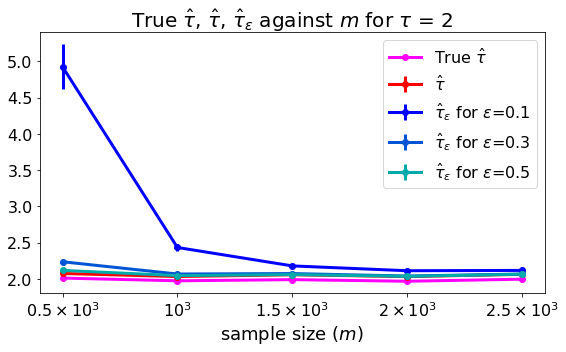

In [10]:
plot_mult_te('sim_tau_'+str(tau)+'_m', te_list, te_hats_list_, ns, nf, epses, tau)